In [2]:
import tensorflow as tf
tf.config.experimental.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
tf.test.is_built_with_cuda()

True

# Importing Libraries

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import os.path as op
import pickle

In [2]:
import tensorflow as tf
from tensorflow import keras
from keras.models import Model,Sequential,load_model
from keras.layers import Input, Embedding
from keras.layers import Dense, Bidirectional
from keras.layers.recurrent import LSTM
import keras.metrics as metrics
import itertools
from tensorflow.python.keras.utils.data_utils import Sequence
from decimal import Decimal
from keras import backend as K
from keras.layers import Conv1D,MaxPooling1D,Flatten,Dense

# Data Fetching

In [4]:
inp=pd.read_csv("../PJ sensor.csv",usecols=[6,7,10,11])
out=pd.read_csv("../PJ sensor.csv",usecols=[2,3,4,5,8,9])

In [5]:
inp.head(5)

,Temperature,Relative Humidity,date,Time
0,31,65,191213,175844
1,31,65,191213,175904
2,31,65,191213,175924
3,31,65,191213,175944
4,31,66,191213,180004


In [6]:
out.head(5)

,NO2,O3,CO,SO2,PM2.5,PM10
0,-15.075377,35.714286,1766.233766,148.484848,11.229150,17.323938
1,-20.100503,41.208791,1733.766234,142.424242,9.413914,24.967407
2,-15.075377,43.956044,1711.038961,136.363636,10.350110,56.781536
3,0.000000,57.692308,1688.311688,139.393939,10.488765,30.371115
4,-20.100503,54.945055,1681.818182,130.303030,12.353048,188.026886


In [7]:
inp=np.array(inp)
out=np.array(out)

# Min Max Scaler

In [8]:
from sklearn.preprocessing import MinMaxScaler
import warnings
scaler_obj=MinMaxScaler()
X1=scaler_obj.fit_transform(inp)
Y1=scaler_obj.fit_transform(out)

warnings.filterwarnings(action='ignore', category=UserWarning)

X1=X1[:,np.newaxis,:]
Y1=Y1[:,np.newaxis,:]

In [9]:
def rmse(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true), axis=-1))

def coeff_determination(y_true, y_pred):
    SS_res =  K.sum(K.square( y_true-y_pred )) 
    SS_tot = K.sum(K.square( y_true - K.mean(y_true) ) ) 
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )

In [10]:
Y1.shape

(1627533, 1, 6)

# Model

In [11]:
model1 = Sequential()
model1.add(keras.Input(shape=(1,4)))
model1.add(tf.keras.layers.GRU(6,activation="relu",use_bias=True,kernel_initializer="glorot_uniform",bias_initializer="zeros", 
                                kernel_regularizer=keras.regularizers.l1_l2(l1=1e-5, l2=1e-4),
                                bias_regularizer=keras.regularizers.l2(1e-4),
                                activity_regularizer=keras.regularizers.l2(1e-5)))
model1.add(keras.layers.Dropout(.1))
model1.add(Dense(6))
model1.add(keras.layers.BatchNormalization(axis=-1,momentum=0.99,epsilon=0.001,center=True,scale=True,
                                beta_initializer="zeros",gamma_initializer="ones",
                                moving_mean_initializer="zeros",moving_variance_initializer="ones",trainable=True))
model1.add(keras.layers.ReLU())
model1.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-5),loss='mse',metrics=['accuracy','mse','mae',rmse])
model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 6)                 216       
                                                                 
 dropout (Dropout)           (None, 6)                 0         
                                                                 
 dense (Dense)               (None, 6)                 42        
                                                                 
 batch_normalization (BatchN  (None, 6)                24        
 ormalization)                                                   
                                                                 
 re_lu (ReLU)                (None, 6)                 0         
                                                                 
Total params: 282
Trainable params: 270
Non-trainable params: 12
_________________________________________________________

In [12]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X1, Y1, test_size=0.25, random_state=42)

model_fit8 = model1.fit(x_train,y_train,batch_size=256,epochs=50, validation_split=0.1)

Epoch 1/50
4292/4292 [==============================] - 62s 14ms/step - loss: 0.2958 - accuracy: 0.2960 - mse: 0.2950 - mae: 0.3770 - rmse: 0.4700 - val_loss: 0.1697 - val_accuracy: 0.3312 - val_mse: 0.1690 - val_mae: 0.3015 - val_rmse: 0.3822
Epoch 2/50
4292/4292 [==============================] - 58s 14ms/step - loss: 0.1734 - accuracy: 0.2962 - mse: 0.1727 - mae: 0.3013 - rmse: 0.3823 - val_loss: 0.0981 - val_accuracy: 0.3752 - val_mse: 0.0974 - val_mae: 0.2242 - val_rmse: 0.3010
Epoch 3/50
4292/4292 [==============================] - 58s 14ms/step - loss: 0.0961 - accuracy: 0.4407 - mse: 0.0954 - mae: 0.2156 - rmse: 0.2914 - val_loss: 0.0636 - val_accuracy: 0.5444 - val_mse: 0.0629 - val_mae: 0.1675 - val_rmse: 0.2434
Epoch 4/50
4292/4292 [==============================] - 59s 14ms/step - loss: 0.0608 - accuracy: 0.5634 - mse: 0.0601 - mae: 0.1620 - rmse: 0.2342 - val_loss: 0.0484 - val_accuracy: 0.5838 - val_mse: 0.0477 - val_mae: 0.1365 - val_rmse: 0.2118
Epoch 5/50
4292/4292 [==

4292/4292 [==============================] - 52s 12ms/step - loss: 0.0042 - accuracy: 0.9970 - mse: 0.0042 - mae: 0.0279 - rmse: 0.0428 - val_loss: 0.0039 - val_accuracy: 0.9971 - val_mse: 0.0039 - val_mae: 0.0403 - val_rmse: 0.0595
Epoch 35/50
4292/4292 [==============================] - 52s 12ms/step - loss: 0.0043 - accuracy: 0.9970 - mse: 0.0042 - mae: 0.0279 - rmse: 0.0427 - val_loss: 0.0038 - val_accuracy: 0.9971 - val_mse: 0.0037 - val_mae: 0.0396 - val_rmse: 0.0584
Epoch 36/50
4292/4292 [==============================] - 53s 12ms/step - loss: 0.0042 - accuracy: 0.9969 - mse: 0.0042 - mae: 0.0278 - rmse: 0.0427 - val_loss: 0.0037 - val_accuracy: 0.9971 - val_mse: 0.0036 - val_mae: 0.0388 - val_rmse: 0.0575
Epoch 37/50
4292/4292 [==============================] - 53s 12ms/step - loss: 0.0042 - accuracy: 0.9969 - mse: 0.0042 - mae: 0.0277 - rmse: 0.0425 - val_loss: 0.0035 - val_accuracy: 0.9971 - val_mse: 0.0035 - val_mae: 0.0380 - val_rmse: 0.0563
Epoch 38/50
4292/4292 [=========

In [13]:
model1.evaluate(x_test,y_test)

12716/12716 [==============================] - 72s 6ms/step - loss: 0.0023 - accuracy: 0.9970 - mse: 0.0023 - mae: 0.0310 - rmse: 0.0446


[0.0022874074056744576,
 0.9970064759254456,
 0.002256193198263645,
 0.031041283160448074,
 0.04461652413010597]

In [14]:
model1.evaluate(x_train,y_train)

38146/38146 [==============================] - 213s 6ms/step - loss: 0.0023 - accuracy: 0.9970 - mse: 0.0023 - mae: 0.0311 - rmse: 0.0446


[0.0022898134775459766,
 0.9969671964645386,
 0.0022585969418287277,
 0.031068842858076096,
 0.04464571550488472]

In [15]:
df1=pd.DataFrame(model_fit8.history['loss'],columns=["Loss"])
df1=df1.join(pd.DataFrame(model_fit8.history["val_loss"],columns=["Val Loss"]))
df1=df1.join(pd.DataFrame(model_fit8.history["accuracy"],columns=['Accuracy']))
df1=df1.join(pd.DataFrame(model_fit8.history["val_accuracy"],columns=['Val Accuracy']))
df1=df1.join(pd.DataFrame(model_fit8.history["mse"],columns=['MSE']))
df1=df1.join(pd.DataFrame(model_fit8.history["val_mse"],columns=['Val MSE']))
df1=df1.join(pd.DataFrame(model_fit8.history["mae"],columns=['MAE']))
df1=df1.join(pd.DataFrame(model_fit8.history["val_mae"],columns=['Val MAE']))
df1=df1.join(pd.DataFrame(model_fit8.history["rmse"],columns=['RMSE']))
df1=df1.join(pd.DataFrame(model_fit8.history["val_mse"],columns=['Val RMSE']))
df1

,Loss,Val Loss,Accuracy,Val Accuracy,MSE,Val MSE,MAE,Val MAE,RMSE,Val RMSE
0,0.295816,0.169706,0.295977,0.331174,0.295038,0.168955,0.377003,0.301518,0.470034,0.168955
1,0.173440,0.098127,0.296206,0.375210,0.172708,0.097408,0.301328,0.224235,0.382333,0.097408
2,0.096065,0.063604,0.440663,0.544448,0.095358,0.062906,0.215589,0.167487,0.291442,0.062906
3,0.060802,0.048356,0.563355,0.583840,0.060117,0.047683,0.161986,0.136548,0.234213,0.047683
4,0.045238,0.040655,0.600948,0.619959,0.044584,0.040021,0.130539,0.116558,0.202033,0.040021
5,0.037199,0.036083,0.629067,0.656066,0.036590,0.035500,0.110515,0.105272,0.180197,0.035500
6,0.032315,0.032454,0.655985,0.695418,0.031759,0.031924,0.097680,0.097352,0.164211,0.031924
7,0.027911,0.028958,0.688903,0.772833,0.027407,0.028474,0.088502,0.093285,0.148716,0.028474
8,0.021191,0.021780,0.733759,0.824239,0.020725,0.021331,0.077440,0.083184,0.124501,0.021331
9,0.015798,0.016520,0.735309,0.881925,0.015363,0.016097,0.065520,0.077337,0.103260,0.016097


In [16]:
df1.to_excel("PJ_GRU.xlsx")

# Saving Model as File

In [17]:
model_json = model1.to_json()
with open("grupj.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model1.save_weights("grupj.h5")
print("Saved model to disk")

Saved model to disk


In [18]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X1, Y1, test_size=0.25, random_state=42)

from keras.models import model_from_json
json_file = open('grupj.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("grupj.h5")
print("Loaded model from disk")
loaded_model.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-5),loss='mse',metrics=['accuracy','mse','mae',rmse])

Loaded model from disk


In [19]:
loaded_model.evaluate(x_train, y_train)

38146/38146 [==============================] - 209s 5ms/step - loss: 0.0023 - accuracy: 0.9970 - mse: 0.0023 - mae: 0.0311 - rmse: 0.0446


[0.0022898134775459766,
 0.9969671964645386,
 0.0022585969418287277,
 0.031068842858076096,
 0.04464571550488472]

In [20]:
loaded_model.evaluate(x_test,y_test)

12716/12716 [==============================] - 70s 6ms/step - loss: 0.0023 - accuracy: 0.9970 - mse: 0.0023 - mae: 0.0310 - rmse: 0.0446


[0.0022874074056744576,
 0.9970064759254456,
 0.002256193198263645,
 0.031041283160448074,
 0.04461652413010597]

# Error Analysis

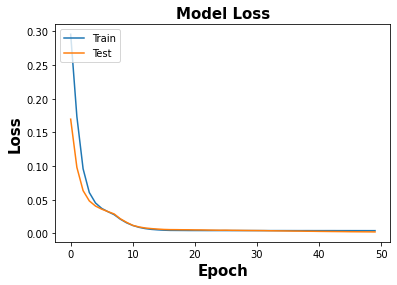

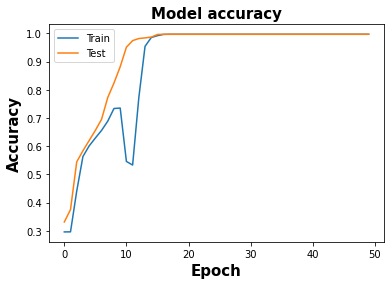

In [21]:
# summarize history for loss
plt.plot(model_fit8.history['loss'])
plt.plot(model_fit8.history['val_loss'])
plt.title('Model Loss',fontweight ='bold',fontsize = 15)
plt.ylabel('Loss',fontweight ='bold',fontsize = 15)
plt.xlabel('Epoch',fontweight ='bold',fontsize = 15)
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# summarize history for accuracy
plt.plot(model_fit8.history['accuracy'])
plt.plot(model_fit8.history['val_accuracy'])
plt.title('Model accuracy',fontweight ='bold',fontsize = 15)
plt.ylabel('Accuracy',fontweight ='bold',fontsize = 15)
plt.xlabel('Epoch',fontweight ='bold',fontsize = 15)
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [22]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X1, Y1, test_size=0.25, random_state=42)

y_test_pred=loaded_model.predict(x_test)
y_test_pred

array([[0.35038012, 0.55445284, 0.        , 0.        , 0.03810433,
        0.        ],
       [0.35012364, 0.55445284, 0.        , 0.        , 0.03808411,
        0.        ],
       [0.3503645 , 0.55445284, 0.        , 0.        , 0.0381024 ,
        0.        ],
       ...,
       [0.35037553, 0.55445284, 0.        , 0.        , 0.03812438,
        0.        ],
       [0.35026377, 0.55445284, 0.        , 0.        , 0.03811779,
        0.        ],
       [0.35045648, 0.55445284, 0.        , 0.        , 0.03811375,
        0.        ]], dtype=float32)

In [23]:
y_test

array([[[0.49655172, 0.61261671, 0.04625328, 0.00839927, 0.07680226,
         0.00349832]],

       [[0.40689655, 0.56779311, 0.02503314, 0.00862807, 0.03923826,
         0.00169898]],

       [[0.48275862, 0.61261671, 0.05669757, 0.01000087, 0.12197674,
         0.0061505 ]],

       ...,

       [[0.4       , 0.53897794, 0.02967504, 0.01022967, 0.04172884,
         0.01677347]],

       [[0.4137931 , 0.56779311, 0.03514586, 0.01114488, 0.06885241,
         0.003031  ]],

       [[0.48275862, 0.57739817, 0.06051056, 0.00908567, 0.10450044,
         0.00542992]]])

In [24]:
y_test=y_test[:,0]

In [25]:
from numpy import savetxt
savetxt('ARRAY_DATA/gru_y_test_pred.csv', y_test_pred[:1001], delimiter=',')

FileNotFoundError: [Errno 2] No such file or directory: 'ARRAY_DATA/gru_y_test_pred.csv'

In [ ]:
from numpy import savetxt
savetxt('ARRAY_DATA/gru_y_test.csv', y_test[:1001], delimiter=',')

In [ ]:
#completed